# Preprocessing brain wave data
* Type
    * audio, visual , audiovisual
* Dimension
    * 2 items ['dataEEG', 'labels']
        * dataEEG: 250 samples, 16 channel, 614 data points
        * labels: 250
* very high frequency
    * 512 Hz
    * ignore first 100 (fisrt few samples are not stable)

In [152]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import glob

audio = glob.glob("../data/sample1/audio/*")
visual = glob.glob("../data/sample1/visual/*")
both = glob.glob("../data/sample1/audiovisual/*")

## Check Files
* file name: s[1~16]\_[A, V, AV]_[test, train].[dat, dat_1, dat_2].npz
    * [1~16] -> subject index
    * [A, V, AV] -> experiment type index
    * [test, train]
        * train: initial trial
        * test: employ trained model

In [153]:
def detail(data):
    print("data size:", len(data))
    d = []
    for d_ in data:
        d__ = np.load(d_)
        d.append(d__)
        print(d_.split('/')[-1], d__.keys(), [d___[1].shape for d___ in d__.items()])
    return d
d = detail(audio)

data size: 49
s10_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s10_A_test.dat_2.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s10_A_test.dat_3.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s10_A_train.dat.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s11_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s11_A_test.dat_2.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s11_A_train.dat.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s12_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s12_A_test.dat_2.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s12_A_train.dat.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s13_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s13_A_test.dat_2.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s13_A_train.dat.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s14_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s14_A_test.dat_2.npz ['labels', 'dataE

## Check the signals
* ***!!! Some Problem !!!***

In [154]:
index = []
for i in audio:
    if "s10" in i:
        index.append(i)
index

['../data/sample1/audio/s10_A_test.dat_1.npz',
 '../data/sample1/audio/s10_A_test.dat_2.npz',
 '../data/sample1/audio/s10_A_test.dat_3.npz',
 '../data/sample1/audio/s10_A_train.dat.npz']

In [155]:
from parse_data import ParseData
parse = ParseData(index)

In [156]:
test_data_1 = parse.test_data[(parse.test_label == 1), :, :]
test_data_0 = parse.test_data[(parse.test_label == 0), :, :]
train_data_1 = parse.train_data[(parse.train_label == 1), :, :]
train_data_0 = parse.train_data[(parse.train_label == 0), :, :]
print(test_data_0.shape, test_data_1.shape)

(600, 16, 614) (150, 16, 614)


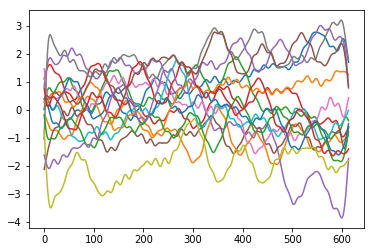

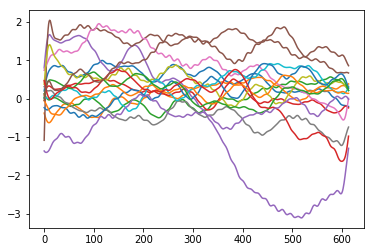

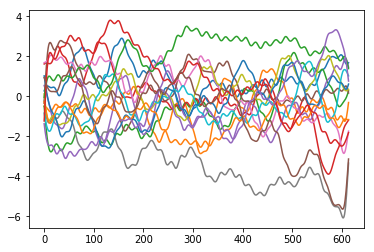

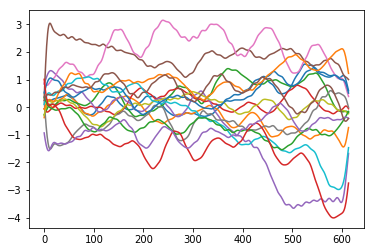

In [228]:
nyq = 256
b, a = signal.butter(3, 0.1/nyq, btype='high')
b_l, a_l = signal.butter(3, 20/nyq, btype='low')

for target in [test_data_1, test_data_0, train_data_1, train_data_0]:
    x, y, z= target.shape
    y = np.zeros((y, z))
    for data_ in target:
        for n, data__ in enumerate(data_):
            y_ = signal.filtfilt(b, a, data__, padlen=None)
            y_ = signal.filtfilt(b_l, a_l, y_, padlen=None)
            y[n, :] = y[n, :] + y_

    for ch in y:
        plt.plot(ch/x)
    plt.show()
    
#     for ch in target.mean(0):
#         plt.plot(ch)
#     plt.show()
    

*** dont match ..... ***

## Filtering (FIR)
* Filters
    * Band pass, High pass, Low pass, High pass -> Low pass
* refference
    * Blog: http://aidiary.hatenablog.com/entry/20111102/1320241544
    * Document: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.lfilter.html
    * Cutting freq: http://www.kimura-lab.net/wp-content/uploads/2012/05/%E3%82%AB%E3%83%83%E3%83%88%E3%82%AA%E3%83%95%E5%91%A8%E6%B3%A2%E6%95%B0%E3%81%AE%E8%A8%AD%E5%AE%9A%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6.pdf

In [14]:
from functions import Filtering
# Frequency
fs = 512

# Nyquist frequency
nyq = fs/2.0  

# Cut off frequency
cut_low = 1/10*nyq
cut_high = 4/5*nyq

# Filtering tup number (need to be odds)
numtaps = 16

flt = Filtering(fs=512, numtaps=numtaps,
                cut_low=cut_low, cut_high=cut_high,
                sampling_rate=3, ignore=None)

# help(Filtering)

In [7]:
def plot_filtered(data):

    # Filtering and plot
    fig = plt.figure(0)
    plt.plot(data)
    plt.title("original")

    y = filtering("m", data, numtaps=21)
    fig = plt.figure(1)
    plt.plot(y)
    plt.title("median")

    y = filtering("b", data, nyq, cut_low=cut_low, cut_high=cut_high, numtaps=numtaps)
    fig = plt.figure(2)
    plt.plot(y)
    plt.title("band pass")

    y = filtering("l", data, nyq, cut_low=cut_low, numtaps=numtaps)
    fig = plt.figure(3)
    plt.plot(y)
    plt.title("low pass")

    y = filtering("h", data, nyq, cut_high=cut_high, numtaps=numtaps)
    fig = plt.figure(4)
    plt.plot(y)
    plt.title("high pass")

    y = filtering("h", data, nyq, cut_high=cut_high, numtaps=numtaps)
    y = filtering("l", y, nyq, cut_low=cut_low, numtaps=numtaps)
    fig = plt.figure(5)
    plt.plot(y)
    plt.title("high pass -> low pass")

    y = filtering("l", data, nyq, cut_low=cut_low,
                  numtaps=numtaps, sampling_rate=2, ignore=100)
    fig = plt.figure(6)
    plt.plot(y)
    plt.title("low pass (down sampled, ignore first 100 sample)")
        
    plt.show()

*** Single channel signal ***

25.6 204.8


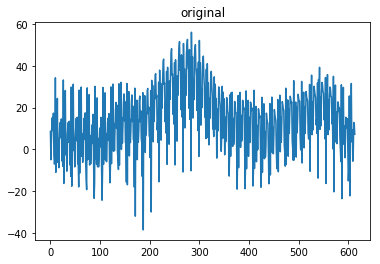

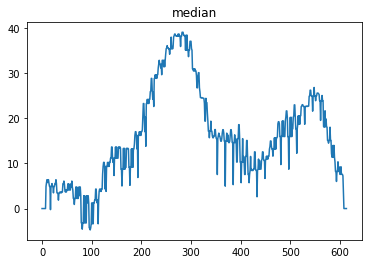

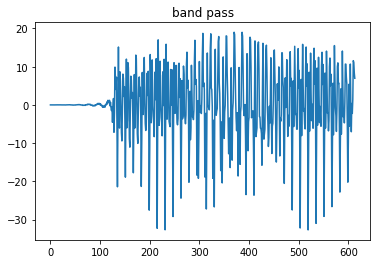

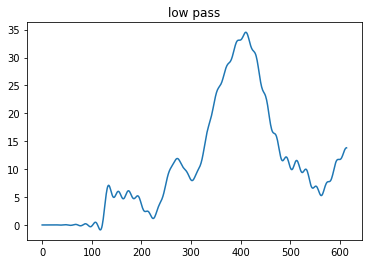

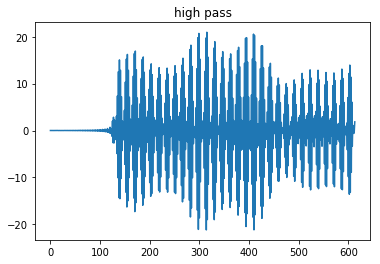

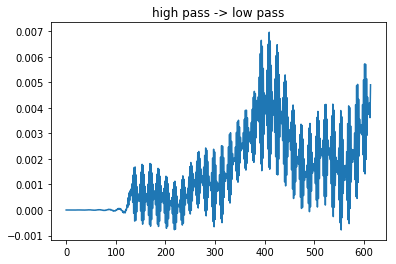

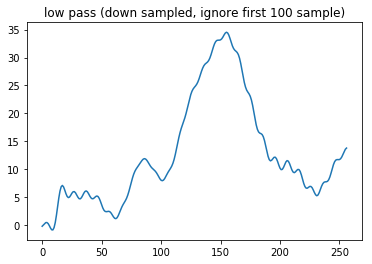

In [8]:
plot_filtered(data[0, :])

*** Averaging all channel signal ***

25.6 204.8


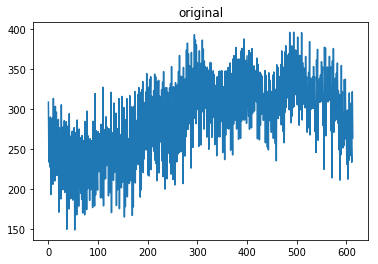

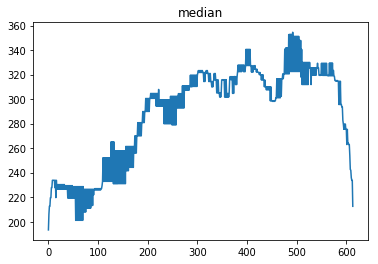

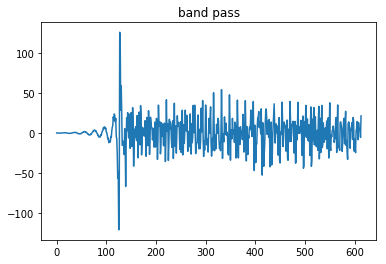

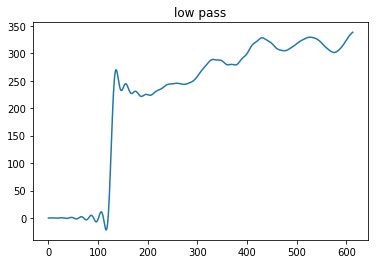

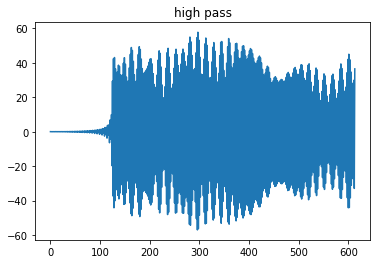

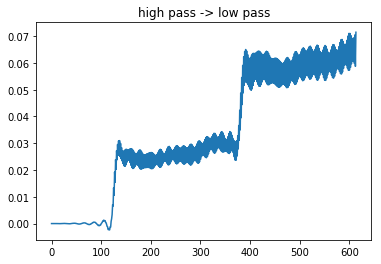

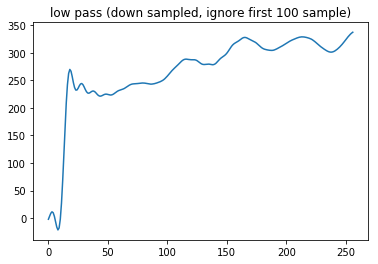

In [9]:
ave = data.sum(0)
plot_filtered(ave)